# Malaria Dataset

Malaria is a disease caused by a parasite. The parasite is transmitted to humans through the bites of infected mosquitoes. People who have malaria usually feel very sick, with a high fever and shaking chills. Each year, approximately 210 million people are infected with malaria, and about 440,000 people die from the disease. Most of the people who die from the disease are young children in Africa.

## Microscopic diagnosis
Malaria parasites can be identified by examining under the microscope a drop of the patient’s blood, spread out as a “blood smear” on a microscope slide. Prior to examination, the specimen is stained (most often with the Giemsa stain) to give the parasites a distinctive appearance. This technique remains the gold standard for laboratory confirmation of malaria. However, it depends on the quality of the reagents, of the microscope, and on the experience of the laboratorian.

The images obtained using microscopic diagnosis was used in the dataset.

![Malaria](./Images/image1.jpg "Title")
<br>
<div style="text-align: center">Courtesy: National Institute of Allergy and Infectious Diseases</div>

## Overview

A convolutional neural network is constructed to classify the data into parasitized and uninfected classes. Additionally, a CNN architecture, InceptionResNetV2 was used for transfer learning.

### Recall
Recall is an evaluation metric where false negatives are minimized. This means that patients that have malaria should not be predicted to not have malaria.

### Transfer learning
Transfer learning is a machine learning technique where a pretrained model is reused to classify a new problem. For example, VGG 19, a CNN model, was used to classify 1000 objects; it can be used to classify malaria by tweaking the top layers of the model.

## Import modules

In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, InceptionResNetV2, NASNetLarge
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import cv2
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import visualkeras

tf.random.set_seed(0)

## Data preprocessing

The data for the two classes was renamed and moved to a new directory to preserve the information of the original data. For each class, the data was manually split into train and test data.

In [2]:
# Get the classes of the images
orig_dir = os.listdir('./cell_images/cell_images')
print(orig_dir)

orig_dir_par = './cell_images/cell_images/Parasitized/'
orig_dir_uni = './cell_images/cell_images/Uninfected/'

# Get the number of items for each class
n_par = len([file for file in os.listdir(orig_dir_par) if file.endswith('.png')])
n_uni = len([file for file in os.listdir(orig_dir_uni) if file.endswith('.png')])
print('The number of parasitized images is', n_par)
print('The number of uninfected images is', n_uni)

['Parasitized', 'Uninfected']
The number of parasitized images is 13779
The number of uninfected images is 13779


Make a directory for the temporary storage of parasitized and uninfected images. This houses the renaming of the images.

In [3]:
# Check if the directory is not yet created
# Make the directory if it is not yet created
temp_dir_par = 'TempParasitized/'
if not os.path.exists(temp_dir_par):
    os.mkdir(temp_dir_par)

temp_dir_uni = 'TempUninfected/'
if not os.path.exists(temp_dir_uni):
    os.mkdir(temp_dir_uni)

In [4]:
def temporary(source, dest):
    
    if source.endswith('Parasitized/'):   
        ctr_par = 0
        for fname_par in os.listdir(source):
            if fname_par.endswith('.png'):
                src = source + fname_par
                dst = dest + 'par' + str(ctr_par) + '.jpeg'
                shutil.copy(src, dst)
                ctr_par +=1
    
    else:
        ctr_uni = 0
        for fname_uni in os.listdir(source):
            if fname_uni.endswith('.png'):
                src = source + fname_uni
                dst = dest + 'uni' + str(ctr_uni) + '.jpeg'
                shutil.copy(src, dst)
                ctr_uni +=1

In [5]:
# Rename the parasitized images and transfer them to the temporary directory

if not len(os.listdir(temp_dir_par)) == n_par:
    temporary(orig_dir_par, temp_dir_par)

if not len(os.listdir(temp_dir_uni)) == n_uni:
    temporary(orig_dir_uni, temp_dir_uni)

### Create a train and test set directories

In [6]:
# Make a train and test directory to store the train and test images.

train_dir = 'train/'
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

test_dir = 'test/'
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

# Separate each class in the train and test directories.
# Create the train parasitized directory
train_dir_par = 'train/parasitized/'
if not os.path.exists(train_dir_par):
    os.mkdir(train_dir_par)

# Create the train uninfected directory
train_dir_uni = 'train/uninfected/'
if not os.path.exists(train_dir_uni):
    os.mkdir(train_dir_uni)

# Create the test parasitized directory
test_dir_par = 'test/parasitized/'
if not os.path.exists(test_dir_par):
    os.mkdir(test_dir_par)

# Create the train uninfected directory
test_dir_uni = 'test/uninfected/'
if not os.path.exists(test_dir_uni):
    os.mkdir(test_dir_uni)

Separate the train and test data. The test data is 20% of the dataset. The train data will be split into train and validation data in the ImageDataGenerator class.

In [7]:
# Compute the number of test data
test_n = int(n_par * 0.2)

# Function to get the images from the temporary directory and transfer them to the train and test directories
def directories(test_n, n_par, source, dest):
    
    if dest.startswith('test'):
        for image_test in range(test_n):
            
            if dest.endswith('parasitized/'):
                src = source + f'par{image_test}' + '.jpeg'
            else:
                src = source + f'uni{image_test}' + '.jpeg'
            
            dst = dest + os.path.basename(src)
            shutil.copyfile(src, dst)
    
    else:
        for image_train in range(test_n, n_par):
            
            if dest.endswith('parasitized/'):
                src = source + f'par{image_train}' + '.jpeg'
            else:
                src = source + f'uni{image_train}' + '.jpeg'
            
            dst = dest + os.path.basename(src)
            shutil.copyfile(src, dst)

In [8]:
# Check if files are complete
# Run the function directories if the files are not complete

# Get the parasitized test data
if not len(os.listdir(test_dir_par)) == test_n:
    directories(test_n, n_par, temp_dir_par, test_dir_par)

# Get the uninfected test data
if not len(os.listdir(test_dir_uni)) == test_n:
    directories(test_n, n_par, temp_dir_uni, test_dir_uni)

# Get the parasitized train data
if not len(os.listdir(train_dir_par)) == (n_par - test_n):
    directories(test_n, n_par, temp_dir_par, train_dir_par)

# Get the uninfected train data
if not len(os.listdir(train_dir_uni)) == (n_par - test_n):
    directories(test_n, n_par, temp_dir_uni, train_dir_uni)

In [9]:
print('Number of parasitized train data:', n_par - test_n)
print('Number of parasitized test data:', test_n)
print('Number of uninfected train data:', n_uni - test_n)
print('Number of uninfected test data:', test_n)

Number of parasitized train data: 11024
Number of parasitized test data: 2755
Number of uninfected train data: 11024
Number of uninfected test data: 2755


## Train and validation split

In [10]:
# Split the train data and validation data with a 80-20 split
data_gen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2, vertical_flip = True, horizontal_flip = True, zoom_range = 0.2, rotation_range = 45)
train_gen = data_gen.flow_from_directory(directory = train_dir, target_size = (128, 128), batch_size = 32, shuffle = True, class_mode = 'binary', subset = 'training', classes = {'Uninfected': 0, 'Parasitized': 1})
validation_gen = data_gen.flow_from_directory(directory = train_dir, target_size = (128, 128), batch_size = 32, shuffle = True, class_mode = 'binary', subset = 'validation', classes = {'Uninfected': 0, 'Parasitized': 1})

Found 17640 images belonging to 2 classes.
Found 4408 images belonging to 2 classes.


## Parasitized images

#### Create a function for the display plot

In [11]:
def display_plot(nrow, ncol, figsize, i, path):
    fig, axes = plt.subplots(nrow, ncol, figsize = figsize)
    #pix = os.listdir(train_dir_par)[:4]
    i = i
    for axis in axes.flatten():
        axis.imshow(cv2.imread(path + os.listdir(path)[i]))
        axis.set_xticks([])
        axis.set_yticks([])
        i +=1

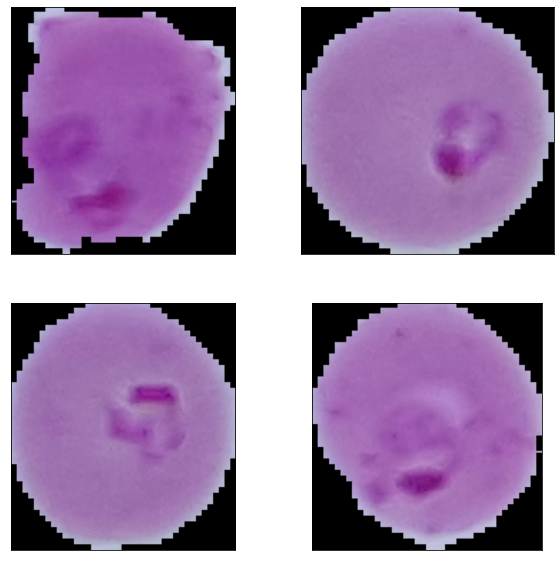

In [12]:
display_plot(2, 2, (10, 10), 0, train_dir_par)

## Uninfected images

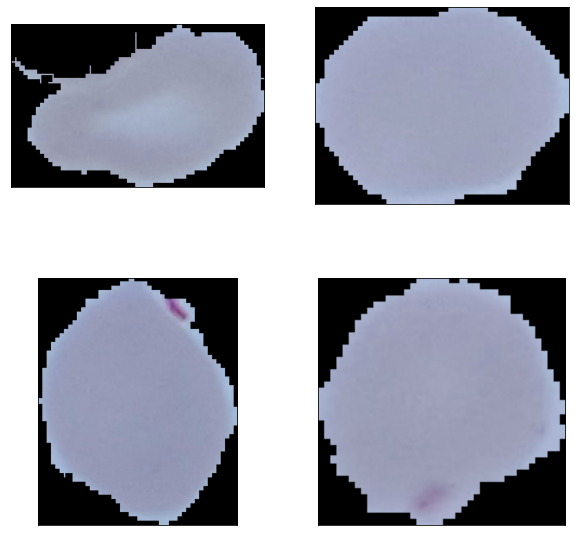

In [13]:
display_plot(2, 2, (10, 10), 0, train_dir_uni)

### Observation:
From the images seen above, parasitized images have some small dark shade of pink, while uninfected images have a uniform color. The model may learn this to distinguish parasitized and uninfected images.

# Build the model

In [14]:
diy_mod = Sequential()

diy_mod.add(Conv2D(16,(4,4),activation='relu',input_shape=(128,128,3)))
diy_mod.add(MaxPool2D(2,2))
diy_mod.add(Dropout(0.2))

diy_mod.add(Conv2D(32,(4,4),activation='relu'))
diy_mod.add(MaxPool2D(2,2))
diy_mod.add(Dropout(0.3))

diy_mod.add(Conv2D(64,(4,4),activation='relu'))
diy_mod.add(MaxPool2D(2,2))
diy_mod.add(Dropout(0.3))

diy_mod.add(Flatten())
diy_mod.add(Dense(64,activation='relu'))
diy_mod.add(Dropout(0.2))

diy_mod.add(Dense(1,activation='sigmoid'))

# Compile the model
opt = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999)
diy_mod.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(name = 'recall')])

In [15]:
diy_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 125, 16)      784       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 59, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        3

### Visualize the model

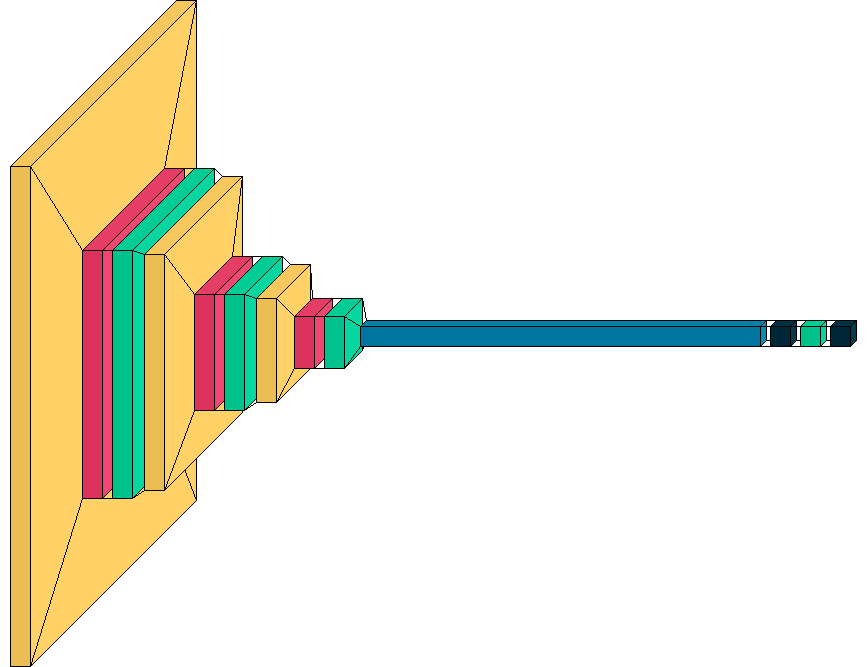

In [16]:
visualkeras.layered_view(diy_mod)

## Model checkpoint
The ModelCheckpoint callback is used in this model to save the best weights of the model. The EarlyStopping callback is not used for this model since it stops the training prematurely.

In [17]:
mod_callback = ModelCheckpoint('diy_mod.h5', monitor="val_loss", save_best_only = True, verbose=1, save_weights_only=True, mode="min")

In [18]:
diy_mod_history = diy_mod.fit(train_gen, steps_per_epoch = len(train_gen), epochs = 20, validation_steps = len(validation_gen),
                                      validation_data = validation_gen, verbose = 1, callbacks = mod_callback)

Epoch 1/20
552/552 [==============================] - ETA: 0s - loss: 0.6697 - accuracy: 0.5840 - recall: 0.5298
Epoch 00001: val_loss improved from inf to 0.67267, saving model to diy_mod.h5
552/552 [==============================] - 94s 170ms/step - loss: 0.6697 - accuracy: 0.5840 - recall: 0.5298 - val_loss: 0.6727 - val_accuracy: 0.6259 - val_recall: 0.6447
Epoch 2/20
552/552 [==============================] - ETA: 0s - loss: 0.6319 - accuracy: 0.6464 - recall: 0.5971
Epoch 00002: val_loss improved from 0.67267 to 0.67012, saving model to diy_mod.h5
552/552 [==============================] - 93s 169ms/step - loss: 0.6319 - accuracy: 0.6464 - recall: 0.5971 - val_loss: 0.6701 - val_accuracy: 0.6289 - val_recall: 0.5563
Epoch 3/20
552/552 [==============================] - ETA: 0s - loss: 0.6202 - accuracy: 0.6565 - recall: 0.6156
Epoch 00003: val_loss improved from 0.67012 to 0.66674, saving model to diy_mod.h5
552/552 [==============================] - 93s 169ms/step - loss: 0.6202

#### Create a function for the metrics plot

In [19]:
def plotter(history):
    
    # Plot the trained and testing loss
    met = [keys for keys in diy_mod_history.history.keys()][:3]
    for key in met:
        plt.figure(dpi = 100, figsize = (6,4))
        plt.plot(history.history[key], label = 'Training', marker = 'o', clip_on = False)
        plt.plot(history.history[f'val_{key}'], label = 'Validation', linestyle = '-', marker = 'o', clip_on = False)
        plt.xlabel('Epoch')
        plt.ylabel(key.capitalize())
        plt.title(f'Model {key.capitalize()}')
        plt.xlim(0, len(history.history[key]) - 1)

        if key == 'loss':
            plt.legend(loc = 'upper right', frameon = False)
        else:
            plt.legend(loc = 'lower right', frameon = False)

            
        plt.gca().set_xticks(range(len(history.history[key])))
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.show()

## Plot the model loss, accuracy, and recall

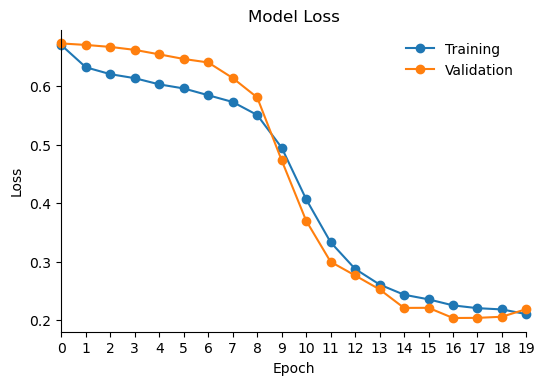

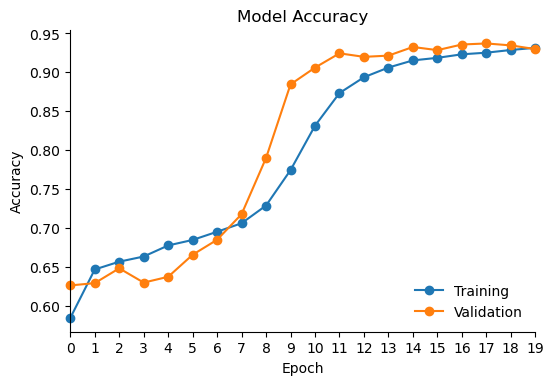

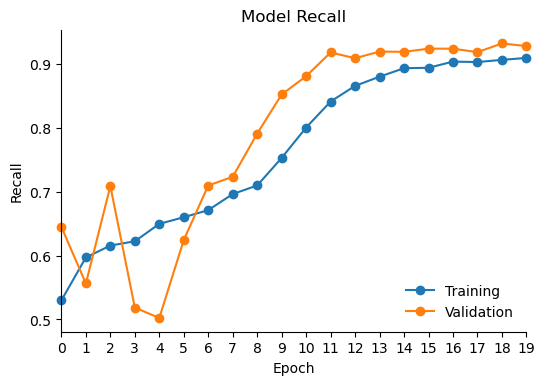

In [20]:
plotter(diy_mod_history)

## Test set prediction
The text on top of each image is the prediction of the model for each image. The higher the probability, the more confident the model is in predicting the image to be parasitized, while the lower the probability, the more confident the model is in predicting the image to be uninfected. The text below each image is the filename of the image which also shows which class each image belongs.

#### Create a function for the prediction plot

In [21]:
def predict_plot(nrow, ncol, figsize, i, model_pred):
    fig, axes = plt.subplots(nrow, ncol, figsize = (12, 12))
    i = i 
    fig.subplots_adjust(hspace = -0.5)
    for axis in axes.flatten():
        axis.imshow(cv2.imread(test_dir + test_gen.filenames[i]))
        if model_pred[i] > 0.5:
            axis.set_title('Parasitized ' + f'{(model_pred[i] * 100).tolist()[0]:.2f}%')
        else:
            axis.set_title('Uninfected ' + f'{(model_pred[i] * 100).tolist()[0]:.2f}%')
        axis.set_xticks([])
        axis.set_yticks([])
        axis.text(0.5,-0.1, str(test_gen.filenames[i]), size=10, ha="center", transform=axis.transAxes)
        i += 1

In [22]:
test_image = ImageDataGenerator(rescale = 1/255)
test_gen = test_image.flow_from_directory(directory = test_dir, target_size = (128, 128), batch_size = 32, shuffle = False, class_mode = 'binary', classes = {'Uninfected': 0, 'Parasitized': 1})
test_gen.reset()
diy_mod_pred = diy_mod.predict(test_gen, verbose = 1)

Found 5510 images belonging to 2 classes.
173/173 [==============================] - 6s 32ms/step


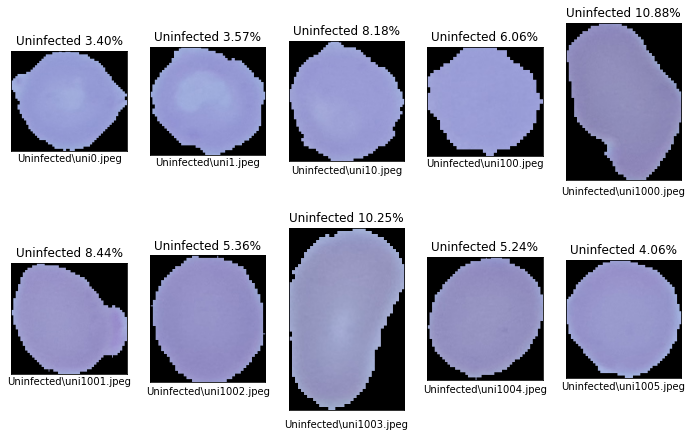

In [23]:
# To show the predictions for the parasitized class, change the value of i from 2755 up to 5500
predict_plot(2, 5, (12, 12), 0, diy_mod_pred)

## Test set evaluation
#### Create a test set evaluation function

In [24]:
def mod_eval(model, test_gen):
    model_eval = model.evaluate(test_gen, verbose=1)
    print(f'The model test loss is {(model_eval[0]*100):.2f}%')
    print(f'The model test accuracy is {(model_eval[1]*100):.2f}%')
    print(f'The model test recall is {(model_eval[2]*100):.2f}%')

In [25]:
mod_eval(diy_mod, test_gen)

173/173 [==============================] - 5s 32ms/step - loss: 0.1872 - accuracy: 0.9394 - recall: 0.9506: 0s - loss: 0.1829 - accuracy: 0.9439 - recall: 0.
The model test loss is 18.72%
The model test accuracy is 93.94%
The model test recall is 95.06%


### Confusion matrix

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

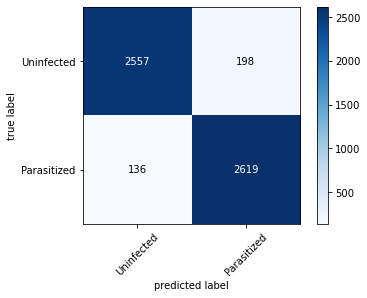

In [26]:
diy_mod_cm = confusion_matrix(test_gen.classes, diy_mod_pred.round())
plot_confusion_matrix(diy_mod_cm, class_names = list(test_gen.class_indices), colorbar = True)

### Classification report

In [27]:
print(f'{classification_report(test_gen.classes, diy_mod_pred.round(), target_names = list(test_gen.class_indices))}')

              precision    recall  f1-score   support

  Uninfected       0.95      0.93      0.94      2755
 Parasitized       0.93      0.95      0.94      2755

    accuracy                           0.94      5510
   macro avg       0.94      0.94      0.94      5510
weighted avg       0.94      0.94      0.94      5510



# Transfer learning using InceptionResNetV2

![Inception](./Images/image2.png "Title")


Image from [Google AI Blog](https://ai.googleblog.com/2016/08/improving-inception-and-image.html)

## Prepare the model
Remove the top layers of the InceptionResNetV2 architecture so it can be used in binary classification instead of classifying 1000 different classes from its original top layers.

In [28]:
IRN_mod = Sequential()
IRN_mod.add(InceptionResNetV2(include_top=False, weights="imagenet", input_shape=(128, 128, 3), pooling='avg', classes=2))

# Add the modified top layers
#IRN_mod.add(Flatten())
IRN_mod.add(Dense(1, activation = 'sigmoid'))
IRN_mod.layers[0].trainable = False

# Compile the model
opt = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999)
IRN_mod.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(name = 'recall')])

IRN_mod.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 1,537
Non-trainable params: 54,336,736
_________________________________________________________________


## Callback
### Early stopping
Early stopping stops the training of the model before the assigned epoch if the performance of the validation set stops improving.

In [29]:
callback = [EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 1, restore_best_weights = True, mode = 'min'),
           ModelCheckpoint('IRN_mod.h5', monitor="val_loss", save_best_only = True, verbose=1, save_weights_only=True, mode="min")]

## Fit the model

In [30]:
IRN_history = IRN_mod.fit(train_gen, steps_per_epoch = len(train_gen), epochs=20, validation_steps = len(validation_gen),
                                      validation_data = validation_gen, verbose=1, callbacks = callback)

Epoch 1/20
552/552 [==============================] - ETA: 0s - loss: 0.5884 - accuracy: 0.6980 - recall: 0.7202
Epoch 00001: val_loss improved from inf to 0.42926, saving model to IRN_mod.h5
552/552 [==============================] - 105s 190ms/step - loss: 0.5884 - accuracy: 0.6980 - recall: 0.7202 - val_loss: 0.4293 - val_accuracy: 0.8097 - val_recall: 0.8625
Epoch 2/20
552/552 [==============================] - ETA: 0s - loss: 0.3738 - accuracy: 0.8431 - recall: 0.8370
Epoch 00002: val_loss improved from 0.42926 to 0.36657, saving model to IRN_mod.h5
552/552 [==============================] - 103s 187ms/step - loss: 0.3738 - accuracy: 0.8431 - recall: 0.8370 - val_loss: 0.3666 - val_accuracy: 0.8407 - val_recall: 0.8666
Epoch 3/20
552/552 [==============================] - ETA: 0s - loss: 0.3289 - accuracy: 0.8662 - recall: 0.8526
Epoch 00003: val_loss improved from 0.36657 to 0.34815, saving model to IRN_mod.h5
552/552 [==============================] - 103s 186ms/step - loss: 0.3

## Plot the model loss, accuracy, and recall

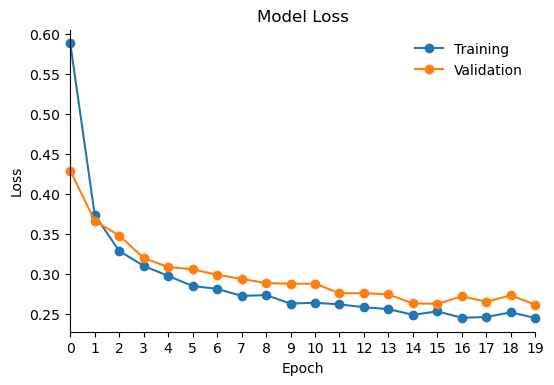

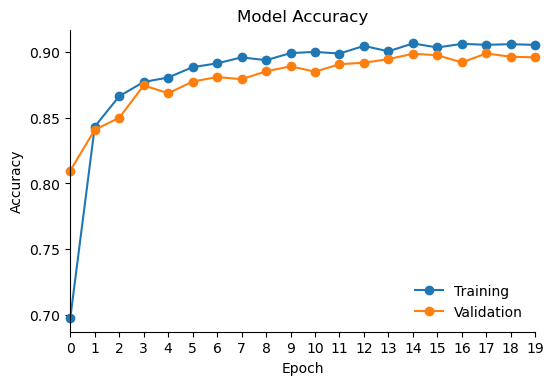

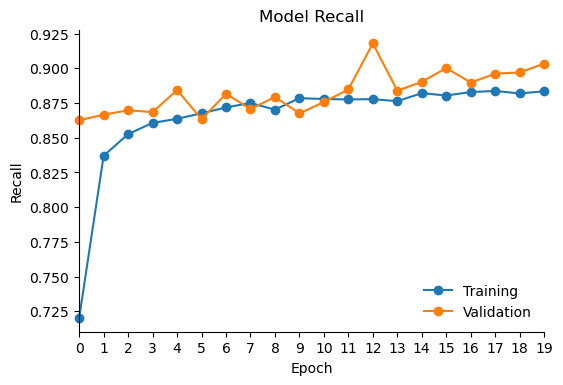

In [31]:
plotter(IRN_history)

## Test set prediction

173/173 [==============================] - 15s 86ms/step


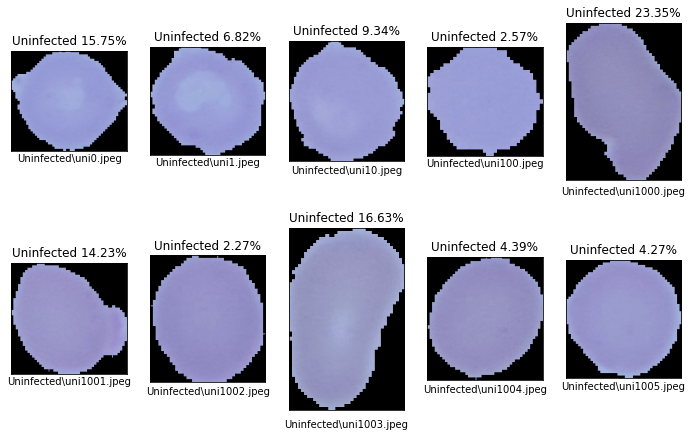

In [32]:
IRN_pred = IRN_mod.predict(test_gen, verbose = 1)

# To show the predictions for the parasitized class, change the value of i from 2755 up to 5500
predict_plot(2, 5, (12, 12), 0, IRN_pred)

## Test set evaluation

In [33]:
mod_eval(IRN_mod, test_gen)

173/173 [==============================] - 15s 88ms/step - loss: 0.2292 - accuracy: 0.9098 - recall: 0.9020
The model test loss is 22.92%
The model test accuracy is 90.98%
The model test recall is 90.20%


### Confusion Matrix

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

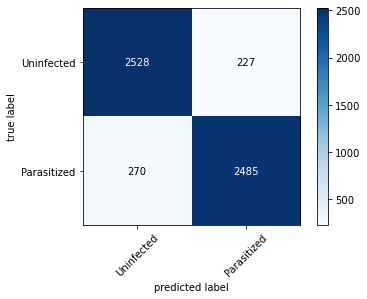

In [34]:
IRN_cm = confusion_matrix(test_gen.classes, IRN_pred.round())
plot_confusion_matrix(IRN_cm, class_names = list(test_gen.class_indices), colorbar = True)

### Classification Report

In [35]:
print(f'{classification_report(test_gen.classes, IRN_pred.round(), target_names = list(test_gen.class_indices))}')

              precision    recall  f1-score   support

  Uninfected       0.90      0.92      0.91      2755
 Parasitized       0.92      0.90      0.91      2755

    accuracy                           0.91      5510
   macro avg       0.91      0.91      0.91      5510
weighted avg       0.91      0.91      0.91      5510



## Comparison

In [36]:
diy_mod_comp = diy_mod.evaluate(test_gen, verbose=0)
IRN_comp = IRN_mod.evaluate(test_gen, verbose=0)

#### Create a function for the comparison graph

In [37]:
def compare(comp1, comp2):
    
    mets = ['Loss', 'Accuracy', 'Recall']
    for idx, val in enumerate(mets):
        y = [0, 0.25]
        label = ['Model', 'InceptionResNetV2']
        fig, ax = plt.subplots(dpi = 100, figsize = (6, 4))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_yticks(y)
        ax.set_yticklabels(label)
        ax.text(comp1[idx] * 100, y[0], f'{(comp1[idx]*100):.2f}%')
        ax.text(comp2[idx] * 100, y[1], f'{(comp2[idx]*100):.2f}%')
        
        plt.style.use('seaborn-pastel')
        plt.barh(0, comp1[idx] * 100, height = 0.1, align = 'center')
        plt.barh(0.25, comp2[idx] * 100, height = 0.1, align = 'center')
        plt.tick_params(axis='y', length = 0)
        plt.suptitle(f'Test {val}', x = 0.51, y = 0.98)
        
        if val == 'Loss':
            plt.title('(Lower is better)', fontsize=10)
        else:
            plt.title('(Higher is better)', fontsize=10)
        
        plt.xlabel(f'% {val}')
        plt.show()

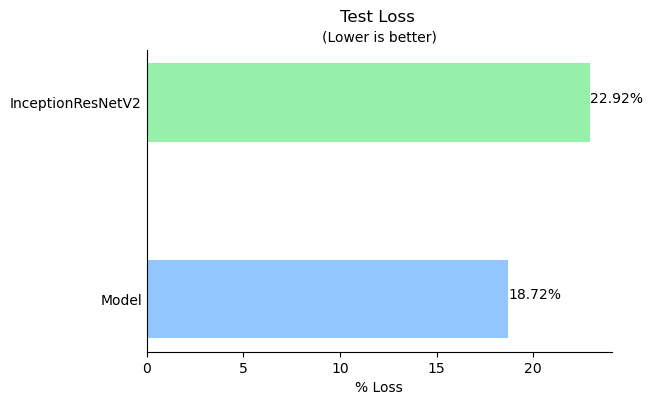

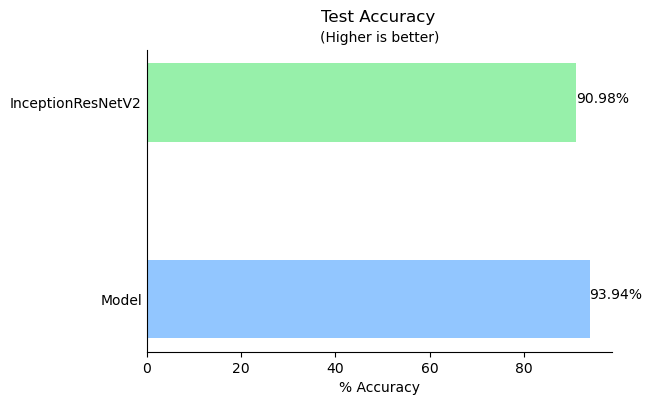

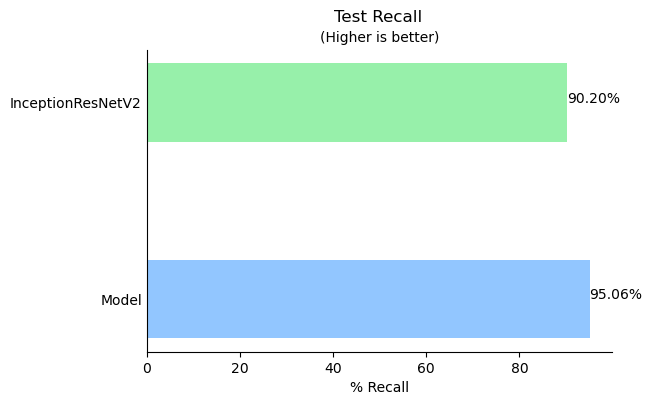

In [39]:
compare(diy_mod_comp, IRN_comp)

## Summary
* Made a simple CNN model with a recall of 93%
* Performed image augmentation using ImageDataGenerator
* Showed the prediction probability of some test images
* Demonstrated transfer learning using InceptionResNetV2
* The model beat the InceptionResNetV2 in classifying parasitized and uninfected images

## Improvements
* Perform data augmentation using machine learning like Generative Adversarial Networks
* Improve the structure of the model (add more layers, add residual networks, etc.)